## Tree Detection with DeepForest

This jupyter notebook uses the python library DeepForest to identify and put bounding boxes around trees.

If using the software, please cite as:
Geographic Generalization in Airborne RGB Deep Learning Tree Detection Ben. G. Weinstein, Sergio Marconi, Stephanie A. Bohlman, Alina Zare, Ethan P. White bioRxiv 790071; doi: https://doi.org/10.1101/790071

Documentation for DeepForest can be found at https://deepforest.readthedocs.io/en/latest/index.html

In [1]:
#Install the deepforest python library. After installing, you may need to restart the kernel before moving to the next code snippet
!pip install DeepForest

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.3/242.3 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.9 MB/s eta 0:00:00
  Created 

In [7]:
# Uninstall the current version of albumentations
!pip uninstall -y albumentations

# Install a compatible version of albumentations
!pip install albumentations==1.4.24

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 20.8 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24


In [1]:
##After restarting the kernel, import libraries into environment...
from deepforest import main
from deepforest import get_data
from deepforest.utilities import boxes_to_shapefile
from deepforest.utilities import shapefile_to_annotations
from deepforest.preprocess import split_raster
from deepforest.visualize import plot_predictions

import matplotlib.pyplot as plt
import os
import time
import numpy
import rasterio
import geopandas as gpd
from rasterio.plot import show
import torch


/usr/local/lib/python3.12/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
#Bring a DeepForest pretrained model into environment. It is trained to identify trees from aerial imagery
#It is located at https://github.com/weecology/DeepForest/releases/tag/1.0.0
model = main.deepforest()
#model.use_release()
model.load_model(model_name="weecology/deepforest-tree", revision="main")

Reading config file: /usr/local/lib/python3.12/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


Reading config file: /usr/local/lib/python3.12/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Predict Tree Crowns on Raw (non-georeferenced images)

In [4]:
#Path for the image you want to ID trees.
#These are non-georeferenced single jpeg drone image located in Cyverse datastore

!wget https://data.cyverse.org/dav-anon/iplant/commons/cyverse_curated/Gillan_Ecosphere_2021/raw_images/May_2019/15-g2/100_0123/100_0123_0086.JPG
image_path = get_data("/content/100_0123_0086.JPG")

!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/DJI_0184.jpeg
image_path2 = get_data("/content/DJI_0184.jpeg")

!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/100_0407_0064.jpeg
image_path3 = get_data("/content/100_0407_0064.jpeg")

!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/DJI_0468.jpeg
image_path4 = get_data("/content/DJI_0468.jpeg")

!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/101_0472_0074.jpeg
image_path5 = get_data("/content/101_0472_0074.jpeg")


--2025-09-09 15:27:18--  https://data.cyverse.org/dav-anon/iplant/commons/cyverse_curated/Gillan_Ecosphere_2021/raw_images/May_2019/15-g2/100_0123/100_0123_0086.JPG
Resolving data.cyverse.org (data.cyverse.org)... 206.207.252.35
Connecting to data.cyverse.org (data.cyverse.org)|206.207.252.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8494591 (8.1M) [application/octet-stream]
Saving to: ‘100_0123_0086.JPG’

100_0123_0086.JPG   100%[===================>]   8.10M  1.77MB/s    in 5.4s    

2025-09-09 15:27:24 (1.50 MB/s) - ‘100_0123_0086.JPG’ saved [8494591/8494591]

--2025-09-09 15:27:24--  https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/DJI_0184.jpeg
Resolving data.cyverse.org (data.cyverse.org)... 206.207.252.35
Connecting to data.cyverse.org (data.cyverse.org)|206.207.252.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447156 (437K) [application/octet-stream]
Saving to: ‘DJI_0184.

In [5]:
#Identify and put bounding boxes around all trees in the image
#This will create a table showing image coordinates of every predicted tree
#The 'score' is the confidence that the prediction is correct. Values closer to 1 are better.
trees = model.predict_image(path=image_path3, return_plot = False)
trees

,xmin,ymin,xmax,ymax,label,score,image_path,geometry
0,107.0,323.0,176.0,385.0,Tree,0.619734,100_0407_0064.jpeg,"POLYGON ((176 323, 176 385, 107 385, 107 323, ..."
1,143.0,69.0,180.0,105.0,Tree,0.554984,100_0407_0064.jpeg,"POLYGON ((180 69, 180 105, 143 105, 143 69, 18..."
2,55.0,23.0,109.0,80.0,Tree,0.527672,100_0407_0064.jpeg,"POLYGON ((109 23, 109 80, 55 80, 55 23, 109 23))"
3,509.0,233.0,541.0,262.0,Tree,0.503346,100_0407_0064.jpeg,"POLYGON ((541 233, 541 262, 509 262, 509 233, ..."
4,557.0,188.0,599.0,228.0,Tree,0.497907,100_0407_0064.jpeg,"POLYGON ((599 188, 599 228, 557 228, 557 188, ..."
5,65.0,231.0,122.0,294.0,Tree,0.458085,100_0407_0064.jpeg,"POLYGON ((122 231, 122 294, 65 294, 65 231, 12..."
6,142.0,142.0,172.0,174.0,Tree,0.440365,100_0407_0064.jpeg,"POLYGON ((172 142, 172 174, 142 174, 142 142, ..."
7,114.0,0.0,141.0,8.0,Tree,0.393911,100_0407_0064.jpeg,"POLYGON ((141 0, 141 8, 114 8, 114 0, 141 0))"
8,101.0,58.0,135.0,92.0,Tree,0.386400,100_0407_0064.jpeg,"POLYGON ((135 58, 135 92, 101 92, 101 58, 135 ..."
9,37.0,218.0,76.0,250.0,Tree,0.372510,100_0407_0064.jpeg,"POLYGON ((76 218, 76 250, 37 250, 37 218, 76 2..."


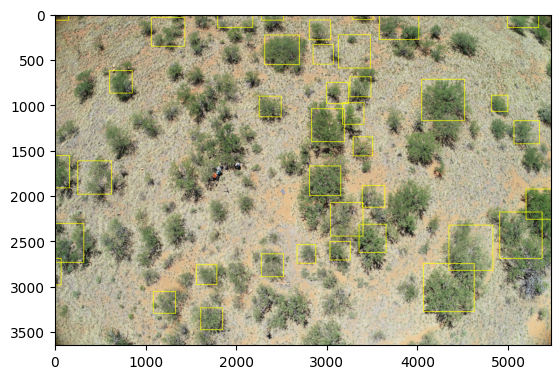

In [7]:
#Show the image with the bounding boxes
plot = model.predict_image(path=image_path, return_plot = True, color=(0, 255, 255), thickness=6)
plt.imshow(plot[:,:,::-1])

## Predict Tree Crowns on Georeferenced Images

In [3]:
#Set the path for a georeferenced image you want to predict tree crowns

#!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/hole_17_ortho_utm.tif
raster_path = get_data("/content/hole_17_ortho_utm.tif")



In [4]:
##Predict tree crowns on a georeferenced image
predicted_raster = model.predict_tile(raster_path, return_plot = True, patch_size=500, patch_overlap=0.25, color=(255, 255, 0), thickness=20)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/call.py", line 49, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 927, in _predict_impl
    results = self._run(model, ckpt_path=ckpt_path)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 1011, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 1050, in _run_stage
    return self.predict_loop.run()
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/utilities.py", line 179, in _decorator
    return loop_run(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

TypeError: object of type 'NoneType' has no len()

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(predicted_raster)
plt.show()

## Improve Model with Training
If the pre-trained model does not identify all trees correclty, then we want to improve the model by adding some training data and fine-tuning the model.
Manual labeling of trees (bounding boxes) can be done in QGIS. The output should be a polygon shapefile (.shp). Instructions for using QGIS is [here](https://github.com/ua-datalab/Geospatial_Workshops/wiki/Drone-Image-Analysis-%E2%80%90-Deep-Forest)

In [ ]:
#Define data paths in preparation to convert .shp to annotation dataframe that can be used for training
## I have found that it is important that the orthomosaic and shapefiles used should have map projections (e.g., UTM). Otherwise, there will be a shift problem in the `shapefile_to_annotations` step.

# training data imagery path
# We are using the golf course orthomosaic geotiff
train_image_path = get_data("/content/hole_17_ortho_utm.tif")

# the directory that has the training data imagery
train_image_dir = os.path.dirname(train_image_path)

# the name of the training imagery
image_name = os.path.basename(train_image_path)

# shapefile path
!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/golf_train_utm.shp
!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/golf_train_utm.shx
!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/golf_train_utm.dbf
!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/golf_train_utm.prj

shp_path = "/content/golf_train_utm.shp"

In [ ]:
## Show shapefile overlayed on orthomosaic

# Open the GeoTIFF file
with rasterio.open(train_image_path) as src:
    fig, ax = plt.subplots(figsize=(20, 20))
    show(src, ax=ax)

    # Read the shapefile
    shapefile = gpd.read_file(shp_path)

    # Plot the shapefile on top of the GeoTIFF
    shapefile.plot(ax=ax, facecolor='none', edgecolor='yellow')

plt.show()

In [ ]:
##Convert .shp (shapefile) to annoation that can be ingested by DeepForest
savedir = "/content"
df = shapefile_to_annotations(shapefile=shp_path, rgb=train_image_path, geometry_type='bbox', savedir=savedir)

In [ ]:
#Write training annotation dataframe to csv file
df.to_csv(os.path.join(savedir, "labels_pixel_coords.csv"), index=False)

In [ ]:
#Show the annotation
df

In [ ]:
## Display the annotation on the orthomosaic

rasterio_src = rasterio.open(train_image_path)

image = rasterio_src.read()
image = numpy.rollaxis(image, 0, 3)

fig = plot_predictions(image, df, color=(255, 255, 0), thickness=20)
plt.figure(figsize=(20, 20))
plt.imshow(fig)

In [ ]:
##This will split a large georeferenced image (and it's labels) into smaller pieces. This prevents running out of memory.
annotation_path = os.path.join(savedir, "labels_pixel_coords.csv")

#create a directory where the smaller images will be stored
crop_dir = os.path.join(savedir, 'train_data')

# Do the split and write out the cropped images as .png files.
#Also write a new annotation table (csv) that lists all of the label coordinates and the cropped image they belong to.
output_crops = split_raster(path_to_raster=train_image_path,
                            annotations_file=annotation_path,
                            base_dir=crop_dir,
                            patch_size=1100,  #1100x1100 pixels
                            patch_overlap=0.25, #cropped image overlap. This is useful because label boxes may be on the edge of cropped images.
                            allow_empty=False)

print(f"Number of tree crown annotations: {len(output_crops)}")
output_crops

### Split annotation data into training and validation

In [ ]:
#identify all of the cropped images as an array
image_paths = output_crops.image_path.unique()

#Of the unique cropped image paths, randomly select 25% of them
validation_paths = numpy.random.choice(image_paths, int(len(image_paths)*0.25))

#Get the individual tree annotation from the 25% cropped images
validation_annotations = output_crops.loc[output_crops.image_path.isin(validation_paths)]

#Get the individual tree annotations from the remaining 75% cropped images
train_annotations = output_crops.loc[~output_crops.image_path.isin(validation_paths)]

#Print out the number of training and testing tree crown annotations
train_annotations.head()
print("There are {} training crown annotations".format(train_annotations.shape[0]))
print("There are {} test crown annotations".format(validation_annotations.shape[0]))

In [ ]:
## Write training and validation annotations to separate csv files

#save to file and create the file dir
training_file= os.path.join(crop_dir,"train.csv")
validation_file= os.path.join(crop_dir,"valid.csv")
#Write window annotations file without a header row, same location as the "base_dir" above.
train_annotations.to_csv(training_file,index=False)
validation_annotations.to_csv(validation_file,index=False)

## Train

In [ ]:
##Set parameters for the training run

#Define the pre-trained model
model = main.deepforest()

model.config['gpus'] = '-1' #move to GPU and use all the GPU resources

#model.config["save-snapshot"] = False
#model.config["train"]["fast_dev_run"] = True

#The annotation table
model.config["train"]["csv_file"] = training_file
#The directory where the training imagery is located
model.config["train"]["root_dir"] = os.path.dirname(training_file)

model.config["score_thresh"] = 0.4
model.config["train"]['epochs'] = 4

model.config["validation"]["csv_file"] = validation_file
model.config["validation"]["root_dir"] = os.path.dirname(validation_file)


model.create_trainer()

model.use_release()


In [ ]:
##TRAIN THE MODEL!
#You can watch the GPU usage by using nvtop (sudo apt install nvtop)
start_time = time.time()
model.trainer.fit(model)
print(f"--- Training on GPU: {(time.time() - start_time):.2f} seconds ---")

## Visualize the prediction after model fine-tuning

In [ ]:
##Predict tree crowns on a georeferenced image
predicted_raster = model.predict_tile(raster_path, return_plot = True, patch_size=1000, patch_overlap=0.25, color=(255, 255, 0), thickness=20)

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(predicted_raster)
plt.show()

## Output and save prediction results for each image crop

In [ ]:
save_dir = os.path.join(savedir, 'pred_result')
os.makedirs(save_dir, exist_ok=True)
results = model.evaluate(training_file, os.path.dirname(training_file), iou_threshold = 0.4, savedir= save_dir)

In [ ]:
## Output and save validation results for each image crop

In [ ]:
save_dir = os.path.join(savedir, 'valid_result')
os.makedirs(save_dir, exist_ok=True)
results = model.evaluate(validation_file, os.path.dirname(validation_file), iou_threshold = 0.4, savedir= save_dir)

## Assessing the Quality of our Tree Predictions

In [ ]:
#show assessment of results
results

In [ ]:
results['results']

In [ ]:
results['box_precision']

In [ ]:
results["box_recall"]

In [ ]:
results["class_recall"]

## Save and load the fine-tuned model

In [ ]:
#Save the fine-tuned model out to your storage
save_model_dir = os.path.join(savedir, 'golf_course_deepforest.pt')
torch.save(model.model.state_dict(),save_model_dir)

In [ ]:
#Bring existing model into environment
fine_tuned_model = main.deepforest()
fine_tuned_model.model.load_state_dict(torch.load(save_model_dir))

## Save Fine-tuned model to Hugging Face

In [ ]:
#Install python libraries that allow you to connect with Hugging Face
!pip install huggingface_hub

In [ ]:
#Input your Hugging Face username toke to authenticate your account
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
#Push fine-tuned model up to Hugging Face
from huggingface_hub import HfApi

# Set up repository details
repo_name = "deepforest_fine_tuning"
model_file = "/content/golf_course_deepforest.pt"

# Create a new repo if it doesn't exist
#api = HfApi()
#api.create_repo(repo_name)

# Upload model to Hugging Face
api.upload_file(
    path_or_fileobj=model_file,   # Path to your .pt file
    repo_id=f"jgillan/{repo_name}",
    path_in_repo="golf_course_deepforest.pt"  # The name you want for the file on the Hub
)


## Download a model from Hugging Face and bring into Colab

In [ ]:

from huggingface_hub import hf_hub_download

# Download the .pt file from Hugging Face
model_file = hf_hub_download(repo_id="jgillan/deepforest_fine_tuning", filename="golf_course_deepforest.pt")

fine_tuned_model = main.deepforest()
fine_tuned_model.model.load_state_dict(torch.load(model_file))